In [91]:
import torch
import random
import math
import numpy as np
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

from games.tree import Tree

In [92]:
# random.seed(32)
# torch.manual_seed(32)
# np.random.seed(32)
# config = {
#     'n_daughters': 7,
#     'depth': 8,
#     'min_depth':2,
#     'sd': 0.1, # standard deviation of the noise for each nodes value
#     'lr': 0.001,
#     'epsilon': 0.7,
#     'epsilon_decay': 0.999,
#     'epochs': 225_000,
# }
config = {
    'n_daughters': 7,
    'depth': 8,
    'min_depth':2,
    'sd': 0.1, # standard deviation of the noise for each nodes value
    'lr': 0.001,
    'epsilon': 0.8,
    'epsilon_decay': 0.999,
    'epochs': 225_000,
}
# max depth is hard coded in the tree class
config['max_depth'] = config['depth']*3
# input dim == number of daughter nodes one hot encoded, for each step in max depth
config['input_dim'] = config['n_daughters'] * config['max_depth']   
# output dim == number of daughter nodes
config['output_dim'] = config['n_daughters']

In [93]:
# policy network, parameterized by path taken to reach a node
#outputs the probability of taking each action
class PolicyNet(torch.nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.n_daughters = config['n_daughters']
        self.input_dim = config['input_dim']
        self.output_dim = config['output_dim']
        self.fc1 = torch.nn.Linear(self.input_dim, 2000)
        self.fc2 = torch.nn.Linear(2000, 1000)
        self.fc3 = torch.nn.Linear(1000, 500)
        self.fc4 = torch.nn.Linear(500, self.output_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x)-> torch.Tensor:
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.nn.functional.softmax(x, dim=-1)
    
def step(node:'Node', action:int)-> Optional['Node']:
    if node.daughters[action] is not None:
        return node.daughters[action]
    return None

def moving_average(values:list, window_size:int)-> List[float]:
    """
    Calculates the moving average of the given list of values, using the specified window size.
    
    :param values: A list of numerical values to smooth.
    :param window_size: The size of the window to use for smoothing, must be an odd number.
    :return: A list of smoothed values.
    """
    if window_size % 2 == 0:
        raise ValueError("Window size must be an odd number")
    
    half_window = window_size // 2
    smoothed_values = []
    
    for i in range(len(values)):
        # Determine the start and end of the window
        start = max(i - half_window, 0)
        end = min(i + half_window + 1, len(values))
        
        # Calculate the average for the current window
        window_average = sum(values[start:end]) / (end - start)
        smoothed_values.append(window_average)
    
    return smoothed_values

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tree = Tree(config['n_daughters'], config['depth'], config['min_depth'], config['sd'])
ideal_path, max_value = tree.ideal_path()
root = tree.root
policy_net = PolicyNet().train().to(device)
optimizer = torch.optim.SGD(policy_net.parameters(), lr=config['lr'])

In [95]:
reward_history = []
cum_reward_history = []
cum_reward = 0

for epoch in range(config['epochs']):
    node = root
    i = 0
    paths =[torch.zeros(config['input_dim'], device=device)]
    rewards = []
    log_actions = []
    actions = []    
    while node.daughters:

        #ask the policy network for the action probabilities
        action_probs = policy_net(paths[-1].to(device))
        action_distribution = torch.distributions.Categorical(action_probs)
        if np.random.rand() < config['epsilon']:
            action = torch.tensor(np.random.choice(config['n_daughters']), device=device)
        else:
            action = action_distribution.sample()
            
        log_prob = action_distribution.log_prob(action)
        log_actions.append(log_prob)
        actions.append(action.item())

        #update the path with the action taken
        new_path = paths[-1].clone()
        new_path[action + (i * config['n_daughters'])] = 1
        paths.append(new_path)

        #take the action
        node = step(node, action)
        rewards.append(node.value())
        i += 1
        

    # calculate the returns
    sum_reward = sum(rewards)
    losses = [-log_prob * sum_reward for log_prob in log_actions]
    loss = torch.stack(losses).sum()
    loss.backward()

    cum_reward += sum_reward
    cum_reward_history.append(cum_reward)
    reward_history.append(sum_reward)


    if epoch % 100 == 0:
        config['epsilon'] *= config['epsilon_decay']
        optimizer.step()
        optimizer.zero_grad()
        print('Taken:',actions)
        print('Ideal:',ideal_path)
        print('Epoch:',epoch,'Epsilon',config['epsilon'],'Cumulative reward:',round(cum_reward,4),' Reward:',round(sum_reward,4))
        print()



Taken: [1, 4]
Ideal: [5, 3, 2, 4]
Epoch: 0 Epsilon 0.7992 Cumulative reward: -0.6526  Reward: -0.6526



Taken: [6, 6, 5]
Ideal: [5, 3, 2, 4]
Epoch: 100 Epsilon 0.7984008 Cumulative reward: -4.2756  Reward: -0.5645

Taken: [1, 1, 2]
Ideal: [5, 3, 2, 4]
Epoch: 200 Epsilon 0.7976023992 Cumulative reward: 14.1736  Reward: -0.2778

Taken: [5, 0]
Ideal: [5, 3, 2, 4]
Epoch: 300 Epsilon 0.7968047968008 Cumulative reward: 10.0894  Reward: 0.8523

Taken: [1, 6]
Ideal: [5, 3, 2, 4]
Epoch: 400 Epsilon 0.7960079920039992 Cumulative reward: -5.8495  Reward: -0.7931

Taken: [2, 4, 4]
Ideal: [5, 3, 2, 4]
Epoch: 500 Epsilon 0.7952119840119952 Cumulative reward: -1.5261  Reward: 1.5576

Taken: [5, 6]
Ideal: [5, 3, 2, 4]
Epoch: 600 Epsilon 0.7944167720279832 Cumulative reward: -3.7186  Reward: 0.678

Taken: [1, 3, 5]
Ideal: [5, 3, 2, 4]
Epoch: 700 Epsilon 0.7936223552559553 Cumulative reward: -27.4172  Reward: -1.2477

Taken: [1, 4]
Ideal: [5, 3, 2, 4]
Epoch: 800 Epsilon 0.7928287329006993 Cumulative reward: -28.8781  Reward: -0.7252

Taken: [2, 3]
Ideal: [5, 3, 2, 4]
Epoch: 900 Epsilon 0.7920359041677987 

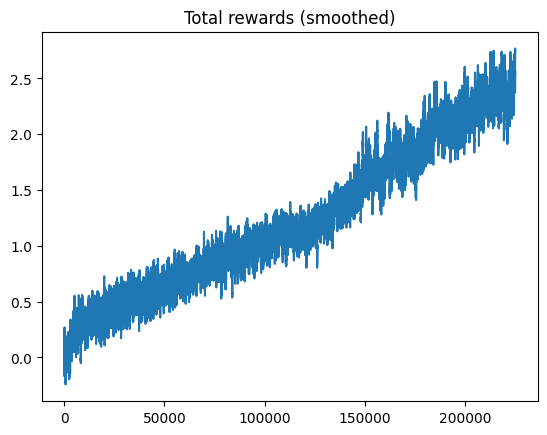

In [96]:
smoothed_rewards = moving_average(reward_history, 101)
plt.plot(smoothed_rewards)
plt.title('Total rewards (smoothed)')
plt.show()

In [97]:
# now run the model to see if it can find the ideal path
node = root
policy_net.eval().to('cpu')
i = 0
paths =[torch.zeros(config['input_dim'])]
rewards = []
actions = []    
while node.daughters:

    #ask the policy network for the action probabilities
    action_probs = policy_net(paths[-1])
    action = torch.argmax(action_probs)
    actions.append(action.item())

    #update the path with the action taken
    new_path = paths[-1].clone()
    new_path[action + (i * config['n_daughters'])] = 1
    paths.append(new_path)

    #take the action
    node = step(node, action)
    rewards.append(node._value)
    i += 1

print('Taken:',actions)
print('Ideal:',ideal_path)
print('Reward:',sum(rewards))
print('Max value:',max_value)

Taken: [5, 3, 2, 4]
Ideal: [5, 3, 2, 4]
Reward: 3.250706584253807
Max value: 3.250706584253807


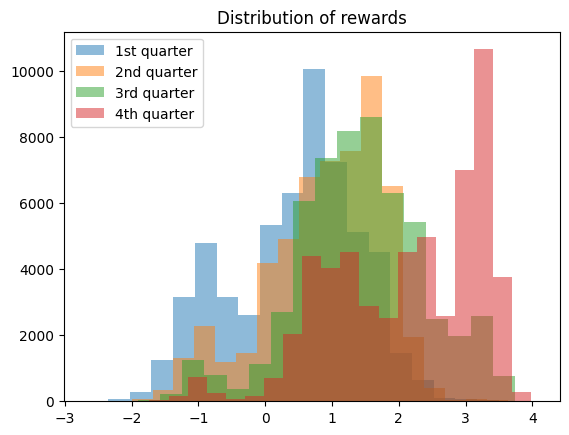

In [98]:
#plot distribution of rewards
#divide rewards into quarters
length = len(reward_history)
r1 = reward_history[:length//4]
r2 = reward_history[length//4:length//2]
r3 = reward_history[length//2:3*length//4]
r4 = reward_history[3*length//4:]

# plot the distributions on 1 graph
plt.hist(r1, bins=20, alpha=0.5, label='1st quarter')
plt.hist(r2, bins=20, alpha=0.5, label='2nd quarter')
plt.hist(r3, bins=20, alpha=0.5, label='3rd quarter')
plt.hist(r4, bins=20, alpha=0.5, label='4th quarter')
plt.legend(loc='upper left')
plt.title('Distribution of rewards')
plt.show()


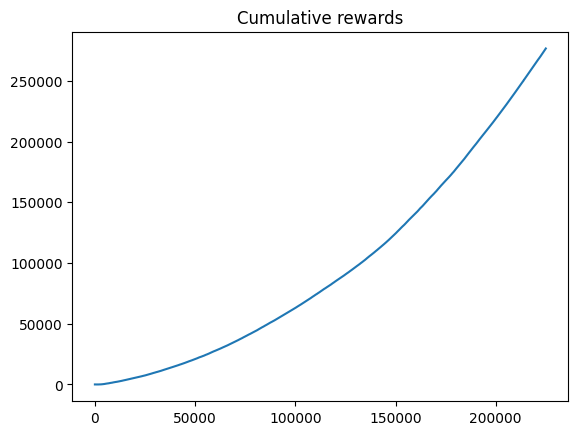

In [99]:
#plot cum reward history
plt.plot(cum_reward_history)
# log y scale
# plt.yscale('log')
plt.title('Cumulative rewards')
plt.show()